In [ ]:
from utils import plot_adjusting_lr, display_accuracy_heatmap, plot_single_model_performance, plot_all_models_performance_from_disk, plot_performance_comparison_from_file

In [11]:
# Diff LR comparisons  
# lr_data = 'run_data\learning_rates\lr_data_50_epochs.json'
lr_data = 'run_data\learning_rates\C2_lr_data_35_epochs.json'

plot_all_models_performance_from_disk(lr_data, enforce_axis=True)
plot_performance_comparison_from_file(lr_data, enforce_axis=True)
display_accuracy_heatmap(lr_data)

NameError: name 'plot_all_models_performance_from_disk' is not defined

In [ ]:
# LR decay comparison and learning rate
lr_decay_data = 'run_data\lr_decay\decaying_lr_comparison_data_50_epochs.json'
plot_all_models_performance_from_disk(lr_decay_data, enforce_axis=True)
plot_performance_comparison_from_file(lr_decay_data, enforce_axis=True)
display_accuracy_heatmap(lr_decay_data)

In [ ]:
import matplotlib.pyplot as plt
def plot_adjusting_lr(initial_lr=0.1, decay_rate=0.05, num_epochs=50):
    
    learning_rates = []
    epochs = list(range(num_epochs))
    for epoch in epochs:
        lr = initial_lr / (1 + decay_rate * epoch)
        learning_rates.append(lr)
        
    print(learning_rates[-5:])
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, learning_rates, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title(f'Adjusting Learning Rate\nInitial LR: {initial_lr}, Decay Rate: {decay_rate}')
    plt.grid(True)
    plt.xticks(range(0, num_epochs, 5))
    plt.ylim(0, 0.1)
    plt.show()
    return 0 
plot_adjusting_lr()

In [ ]:
# DR rates comparison

dr_data = f'./run_data/dropout/dropout_data_{num_epochs}_epochs.json'
plot_all_models_performance_from_disk(dr_data, enforce_axis=True)
plot_performance_comparison_from_file(dr_data, enforce_axis=True)
display_accuracy_heatmap(dr_data)

In [ ]:
# with dr vs without dr ORIGINAL data compare:

compare_original_data = f'./run_data/dropout/dropout_model_comparison_original_data_{num_epochs}_epochs.json'

plot_all_models_performance_from_disk(compare_original_data, enforce_axis=True)
plot_performance_comparison_from_file(compare_original_data, enforce_axis=True)
display_accuracy_heatmap(compare_original_data)

# with dr vs without dr SWAPPED data compare:

compare_swapped_data = f'./run_data/dropout/dropout_model_comparison_swapped_data_{num_epochs}_epochs.json'

plot_all_models_performance_from_disk(compare_swapped_data, enforce_axis=True)
plot_performance_comparison_from_file(compare_swapped_data, enforce_axis=True)
display_accuracy_heatmap(compare_swapped_data)

In [1]:
# 1. imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import pandas as pd
import json
import importlib
import math



try:
    from IPython import get_ipython
    if 'IPKernelApp' not in get_ipython().config:  # Not in a notebook
        from tqdm import tqdm
    else:  # In a notebook
        from tqdm.notebook import tqdm
except ImportError:  # IPython is not installed
    from tqdm import tqdm
import utils
from utils import display_accuracy_heatmap, get_accuracy, run_training_and_validation, plot_single_train_val_smoothed, run_testing, BaselineNet, DropoutNet

# importlib.reload(utils)


# 2. set up for using GPU if available (with printed confirmation)  
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# 3. checking environment 
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False
print(f"IN_COLAB= {IN_COLAB}")

# 4. get the data for the task (for baseline, no transforms applied, simple train/test split used)
# This is the equivalent of building an instance of the pytorch 'Dataset' class using the CIFAR dataset 
# Each dataset can be indexed into and each individual sample is a tuple of the form (image, target) where target is index of the target class ref https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10.
# a simple train/test split 

batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

num_validation_samples = 5000
num_train_samples = len(train_data) - num_validation_samples

train_data, val_data = random_split(train_data, [num_train_samples, num_validation_samples])

print(len(train_data)) # 50000 training egs  
print(len(val_data)) # 10000 test egs
print(len(test_data)) # 10000 test egs

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Using cuda device
IN_COLAB= False
Files already downloaded and verified
45000
5000
10000


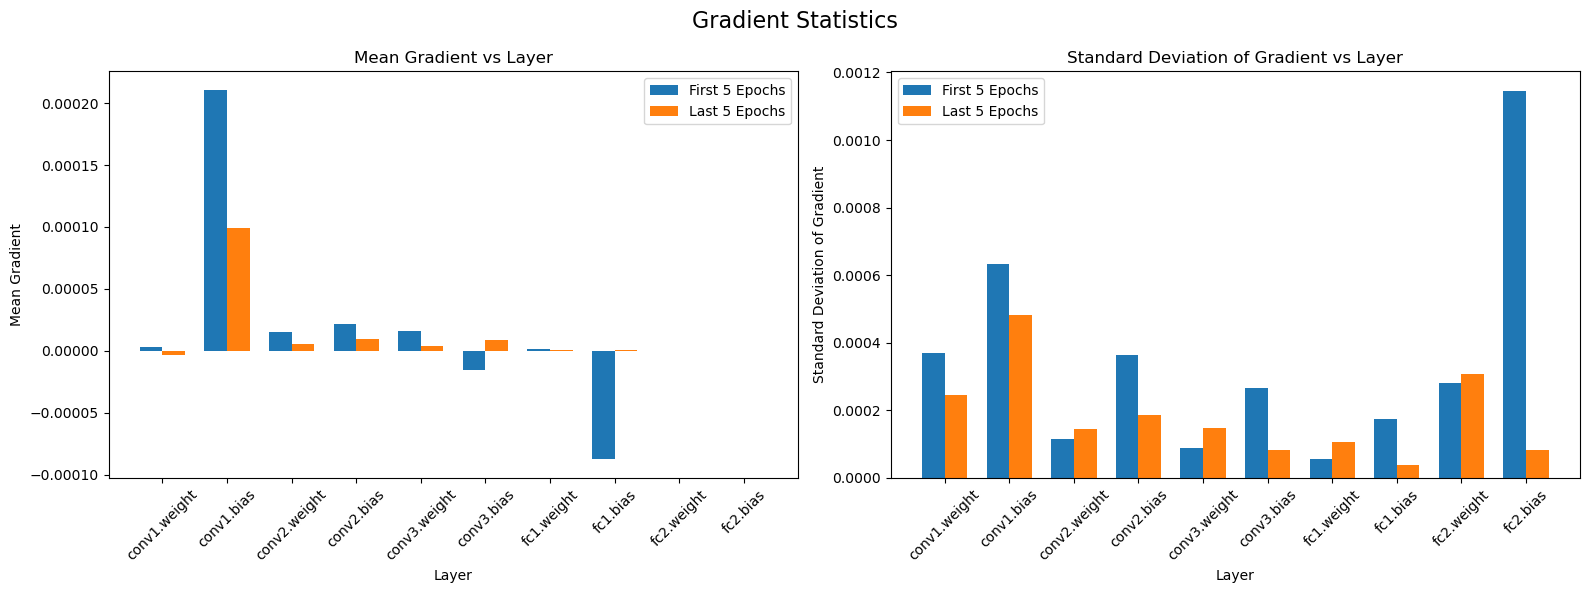

In [6]:
from utils import plot_gradient_statistics, compute_gradient_statistics, collect_gradients

num_epochs = 30
non_drop_model = BaselineNet(0)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(non_drop_model.parameters(), lr=0.1)

first_5_epochs_gradients_non_drop, last_5_epochs_gradients_non_drop = collect_gradients(non_drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop = compute_gradient_statistics(first_5_epochs_gradients_non_drop)
last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop = compute_gradient_statistics(last_5_epochs_gradients_non_drop)

plot_gradient_statistics(first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop, last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop)


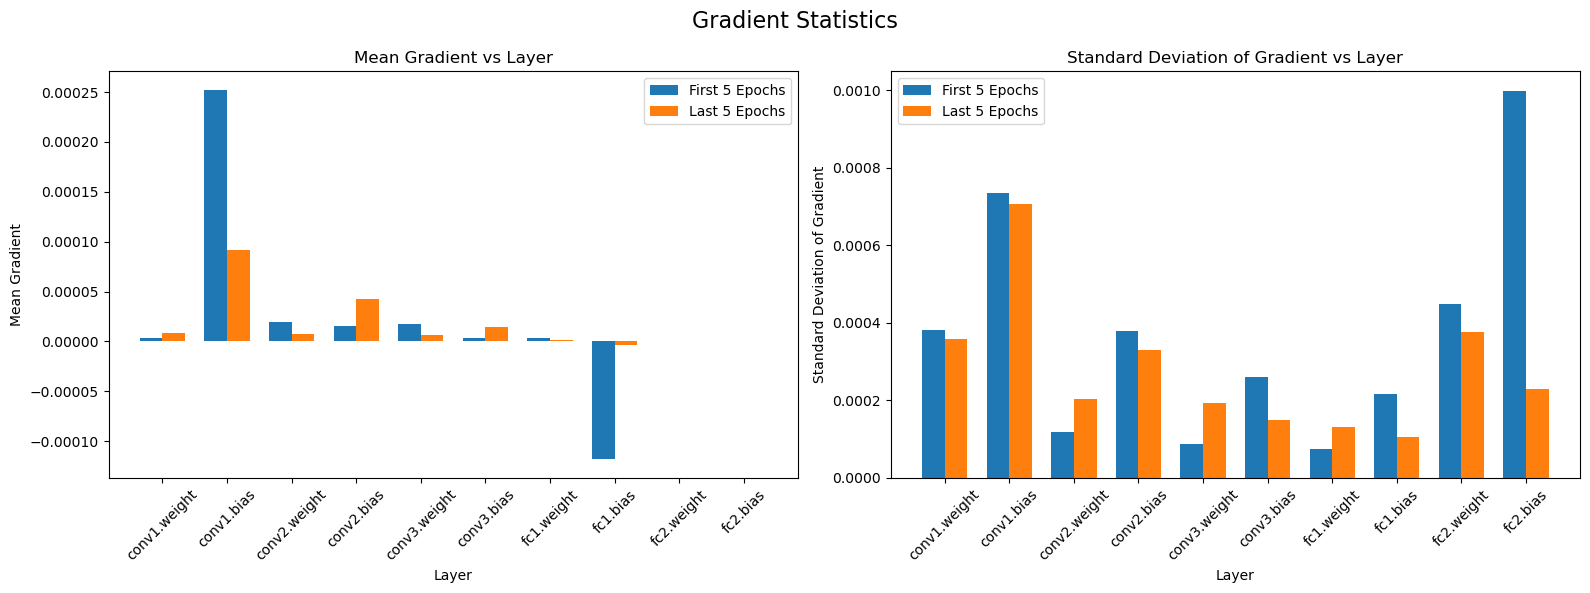

In [7]:
num_epochs = 30
drop_model = DropoutNet(0.6, 0)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(drop_model.parameters(), lr=0.1)

first_5_epochs_gradients_dropout, last_5_epochs_gradients_dropout = collect_gradients(drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_dropout, first_5_std_gradients_dropout = compute_gradient_statistics(first_5_epochs_gradients_dropout)
last_5_mean_gradients_dropout, last_5_std_gradients_dropout = compute_gradient_statistics(last_5_epochs_gradients_dropout)

plot_gradient_statistics(first_5_mean_gradients_dropout, first_5_std_gradients_dropout, last_5_mean_gradients_dropout, last_5_std_gradients_dropout)


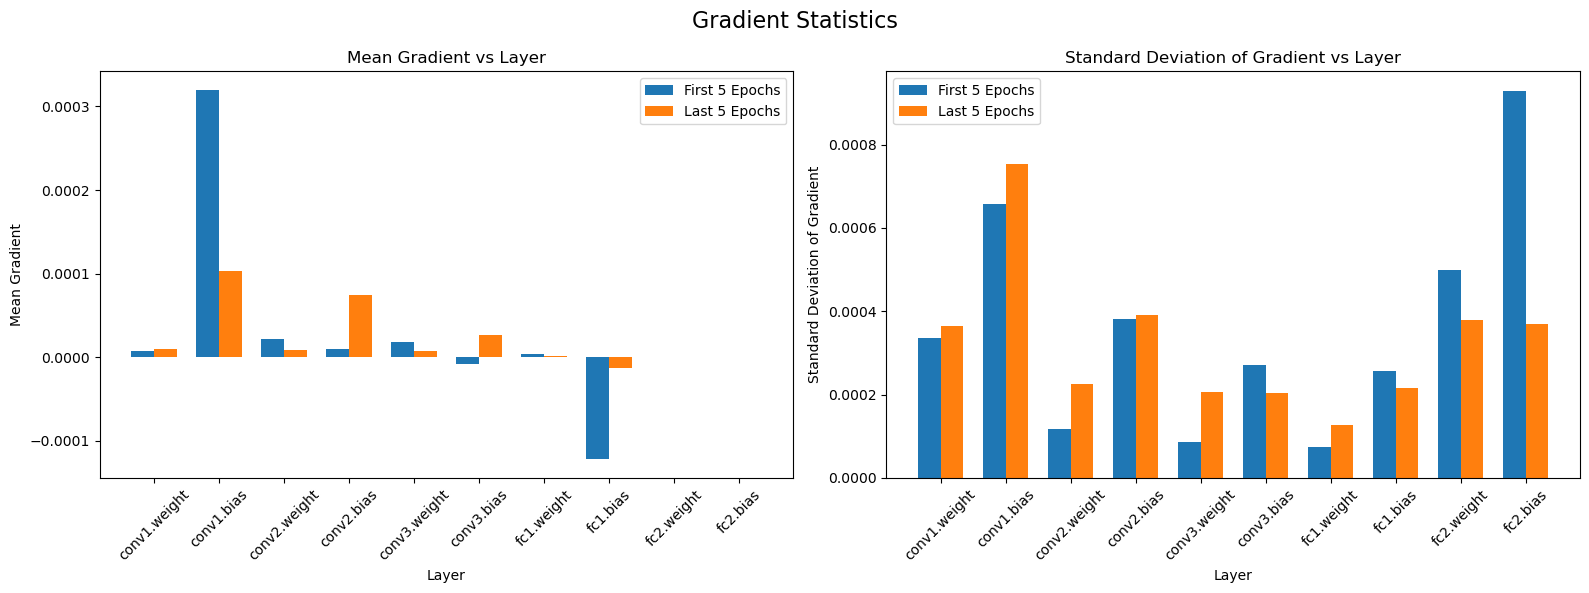

In [8]:
from utils import plot_gradient_statistics, compute_gradient_statistics, collect_gradients
num_epochs = 30
drop_model = DropoutNet(0.8, 0)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(drop_model.parameters(), lr=0.1)

first_5_epochs_gradients_dropout, last_5_epochs_gradients_dropout = collect_gradients(drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_dropout, first_5_std_gradients_dropout = compute_gradient_statistics(first_5_epochs_gradients_dropout)
last_5_mean_gradients_dropout, last_5_std_gradients_dropout = compute_gradient_statistics(last_5_epochs_gradients_dropout)

plot_gradient_statistics(first_5_mean_gradients_dropout, first_5_std_gradients_dropout, last_5_mean_gradients_dropout, last_5_std_gradients_dropout)


In [ ]:
plot_gradient_statistics(first_5_mean_gradients_dropout, first_5_std_gradients_dropout, last_5_mean_gradients_dropout, last_5_std_gradients_dropout)
plot_gradient_statistics(first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop, last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop)


In [2]:
class BatchNormNet(nn.Module):
    def __init__(self, random_seed):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=128)
        self.bn4 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.fc2(x)
        return x
    


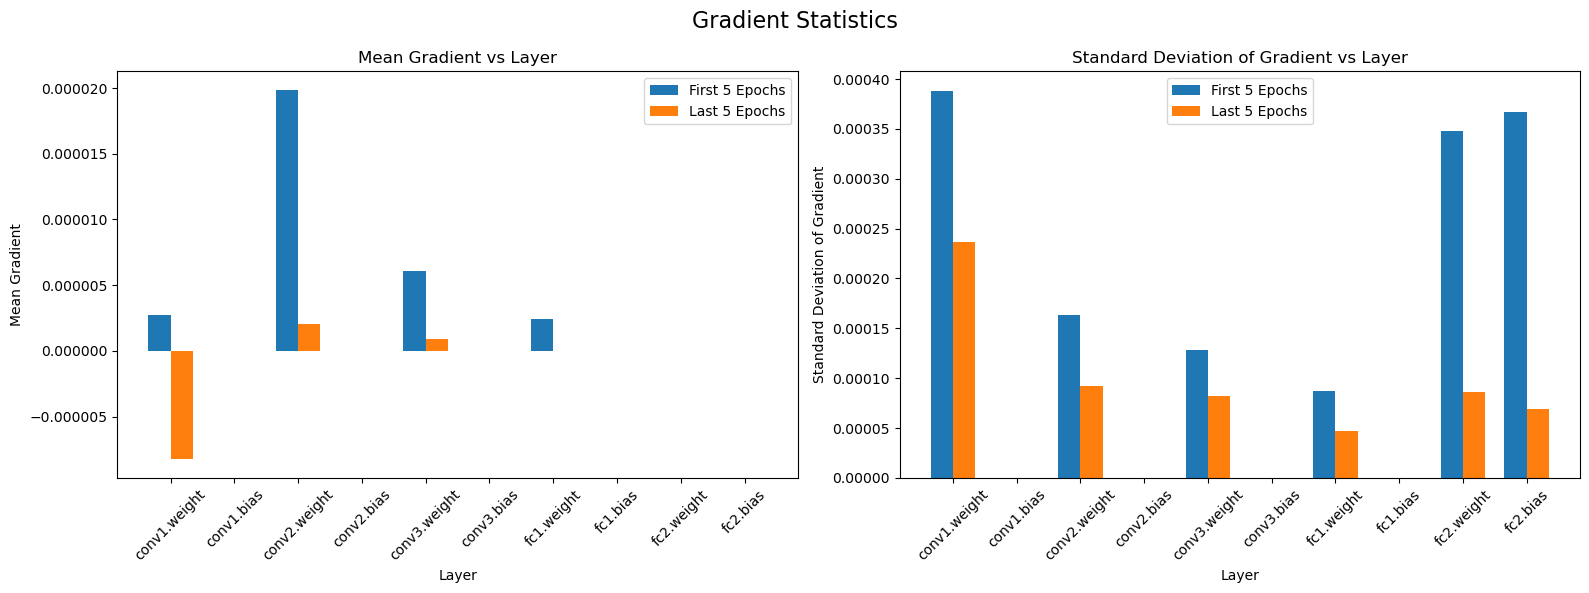

In [14]:
num_epochs = 30
bn_model = BatchNormNet(0)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(bn_model.parameters(), lr=0.1)

first_5_epochs_gradients_bn, last_5_epochs_gradients_bn = collect_gradients(bn_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_bn, first_5_std_gradients_bn = compute_gradient_statistics(first_5_epochs_gradients_bn)
last_5_mean_gradients_bn, last_5_std_gradients_bn = compute_gradient_statistics(last_5_epochs_gradients_bn)

plot_gradient_statistics(first_5_mean_gradients_bn, first_5_std_gradients_bn, last_5_mean_gradients_bn, last_5_std_gradients_bn)


MODEL:  0
seed: 0
Epoch [1/50] - Train Loss: 1.7756, Acc: 0.3477 | Val Loss: 1.7458, Acc: 0.3742
Epoch [2/50] - Train Loss: 1.2868, Acc: 0.5380 | Val Loss: 1.3831, Acc: 0.5142
Epoch [3/50] - Train Loss: 1.0370, Acc: 0.6338 | Val Loss: 1.3317, Acc: 0.5421
Epoch [4/50] - Train Loss: 0.8667, Acc: 0.6961 | Val Loss: 1.6454, Acc: 0.4905
Epoch [5/50] - Train Loss: 0.7445, Acc: 0.7381 | Val Loss: 1.3533, Acc: 0.5943
Epoch [6/50] - Train Loss: 0.6438, Acc: 0.7757 | Val Loss: 1.1151, Acc: 0.6481
Epoch [7/50] - Train Loss: 0.5485, Acc: 0.8065 | Val Loss: 1.6183, Acc: 0.5235
Epoch [8/50] - Train Loss: 0.4690, Acc: 0.8352 | Val Loss: 0.8565, Acc: 0.7316
Epoch [9/50] - Train Loss: 0.3855, Acc: 0.8636 | Val Loss: 1.5005, Acc: 0.6208
Epoch [10/50] - Train Loss: 0.3223, Acc: 0.8861 | Val Loss: 3.5532, Acc: 0.4858
Epoch [11/50] - Train Loss: 0.2874, Acc: 0.8988 | Val Loss: 0.9713, Acc: 0.7447
Epoch [12/50] - Train Loss: 0.2068, Acc: 0.9274 | Val Loss: 1.3795, Acc: 0.6944
Epoch [13/50] - Train Loss: 0.1

c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/50] - Train Loss: 1.7838, Acc: 0.3502 | Val Loss: 1.6101, Acc: 0.3904
Epoch [2/50] - Train Loss: 1.2920, Acc: 0.5360 | Val Loss: 1.8626, Acc: 0.4555
Epoch [3/50] - Train Loss: 1.0362, Acc: 0.6339 | Val Loss: 1.6489, Acc: 0.4614
Epoch [4/50] - Train Loss: 0.8668, Acc: 0.6962 | Val Loss: 2.5139, Acc: 0.3859
Epoch [5/50] - Train Loss: 0.7555, Acc: 0.7342 | Val Loss: 1.1527, Acc: 0.6195
Epoch [6/50] - Train Loss: 0.6340, Acc: 0.7779 | Val Loss: 0.8251, Acc: 0.7146
Epoch [7/50] - Train Loss: 0.5441, Acc: 0.8085 | Val Loss: 1.4069, Acc: 0.5943
Epoch [8/50] - Train Loss: 0.4618, Acc: 0.8377 | Val Loss: 0.8267, Acc: 0.7280
Epoch [9/50] - Train Loss: 0.3821, Acc: 0.8663 | Val Loss: 1.0848, Acc: 0.6972
Epoch [10/50] - Train Loss: 0.3120, Acc: 0.8910 | Val Loss: 1.1719, Acc: 0.7000
Epoch [11/50] - Train Loss: 0.2567, Acc: 0.9091 | Val Loss: 1.2919, Acc: 0.6911
Epoch [12/50] - Train Loss: 0.2114, Acc: 0.9254 | Val Loss: 1.0712, Acc: 0.7310
Epoch [13/50] - Train Loss: 0.1719, Acc: 0.9391 |

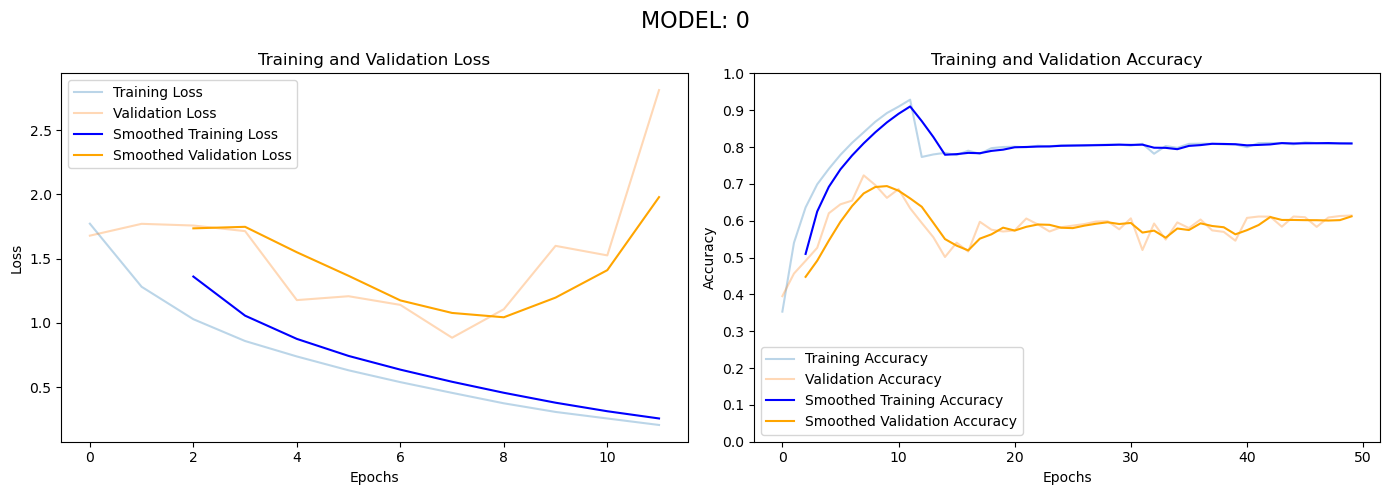

MODEL:  1
seed: 0
Epoch [1/50] - Train Loss: 1.1439, Acc: 0.5920 | Val Loss: 0.9897, Acc: 0.6566
Epoch [2/50] - Train Loss: 0.7935, Acc: 0.7228 | Val Loss: 0.8465, Acc: 0.7067
Epoch [3/50] - Train Loss: 0.6412, Acc: 0.7754 | Val Loss: 3.0101, Acc: 0.3439
Epoch [4/50] - Train Loss: 0.5343, Acc: 0.8147 | Val Loss: 2.1830, Acc: 0.5303
Epoch [5/50] - Train Loss: 0.4401, Acc: 0.8465 | Val Loss: 0.8725, Acc: 0.7124
Epoch [6/50] - Train Loss: 0.3567, Acc: 0.8756 | Val Loss: 0.8574, Acc: 0.7326
Epoch [7/50] - Train Loss: 0.2828, Acc: 0.9035 | Val Loss: 2.3689, Acc: 0.5243
Epoch [8/50] - Train Loss: 0.2353, Acc: 0.9192 | Val Loss: 0.8360, Acc: 0.7631
Epoch [9/50] - Train Loss: 0.1736, Acc: 0.9414 | Val Loss: 1.9815, Acc: 0.5999
Epoch [10/50] - Train Loss: 0.1427, Acc: 0.9519 | Val Loss: 0.8306, Acc: 0.7741
Epoch [11/50] - Train Loss: 0.1077, Acc: 0.9655 | Val Loss: 2.2385, Acc: 0.5700
Epoch [12/50] - Train Loss: 0.1030, Acc: 0.9662 | Val Loss: 1.2253, Acc: 0.7085
Epoch [13/50] - Train Loss: 0.0

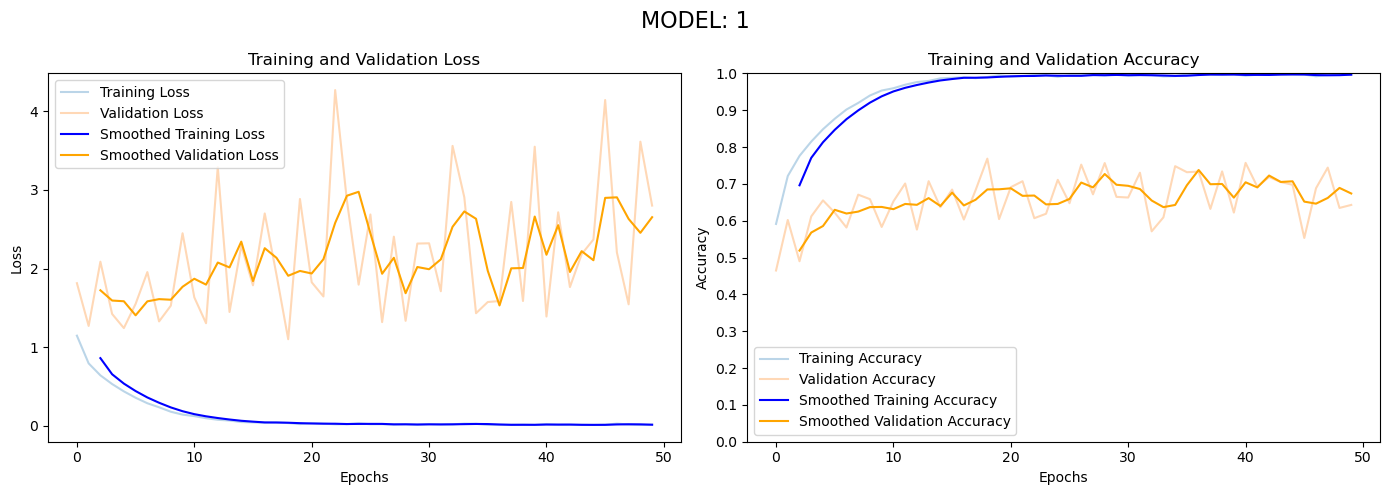

In [4]:
# batch norm learning curves for comparison

num_epochs = 50
learning_rate = 0.1
random_seeds = list(range(5))


path_to_save = f'./run_data/batch_norm/batch_norm_comparison_{num_epochs}_epochs.json'
path_to_load = f'./run_data/batch_norm/batch_norm_comparison_{num_epochs}_epochs.json'

models = [0, 1]
averaged_results = {i:{} for i in models}

save_experiment = True

# train them both on the original data
for i, model in enumerate(models):
    epoch_train_losses_by_run = []
    epoch_val_losses_by_run = []
    epoch_train_accuracies_by_run = []
    epoch_val_accuracies_by_run = []
    test_losses = []
    test_accuracies = []
    reports = []
    
    for random_seed in random_seeds:
        print('MODEL: ', i) 
        print('seed:', random_seed)
        model = BaselineNet(random_seed=random_seed) if i == 0 else BatchNormNet(random_seed=random_seed)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimiser = optim.SGD(model.parameters(), lr=learning_rate)
        model, train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, _,_ = run_training_and_validation(model, device, learning_rate, num_epochs, criterion, optimiser, train_dataloader, val_dataloader, metrics = False, manual_lr_schedule=False)
        epoch_train_losses_by_run.append(train_epoch_losses)
        epoch_val_losses_by_run.append(val_epoch_losses)
        epoch_train_accuracies_by_run.append(train_epoch_accuracy)
        epoch_val_accuracies_by_run.append(val_epoch_accuracy)
        
        test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        reports.append(report)
        
    average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
    average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
    average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
    average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
    average_test_loss = sum(test_losses)/len(test_losses)
    average_test_accuracy = sum(test_accuracies)/len(test_accuracies)
    
    averaged_results[i] = {'seeds':random_seeds,'av_train_losses': average_train_losses,
                                       'av_val_losses': average_val_losses,
                                       'av_train_acc': average_train_accuracies,
                                       'av_val_acc': average_val_accuracies,
                                       'all_train_losses':epoch_train_losses_by_run,
                                       'all_val_losses': epoch_val_losses_by_run,
                                       'all_train_accuracies': epoch_train_accuracies_by_run,
                                       'all_val_accuracies': epoch_val_accuracies_by_run,
                                       'all_test_losses':test_losses, 
                                       'all_test_accuracies':test_accuracies,
                                       'av_test_loss': average_test_loss,
                                       'av_test_accuracy':average_test_accuracy}
    print('average for ')
    print('Model: ', i) 
    plot_single_train_val_smoothed(average_train_losses,average_val_losses,average_train_accuracies,average_val_accuracies, num_epochs, smoothing_window=3, title=f'MODEL: {i}')
    
    
if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read

In [1]:
# 1. imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import pandas as pd
import json
import importlib
import math



try:
    from IPython import get_ipython
    if 'IPKernelApp' not in get_ipython().config:  # Not in a notebook
        from tqdm import tqdm
    else:  # In a notebook
        from tqdm.notebook import tqdm
except ImportError:  # IPython is not installed
    from tqdm import tqdm
import utils
from utils import *

# importlib.reload(utils)


# 2. set up for using GPU if available (with printed confirmation)  
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [2]:
batch_size = 64

torch.manual_seed(0)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

num_validation_samples = 5000
num_train_samples = len(train_data) - num_validation_samples

train_data, val_data = random_split(train_data, [num_train_samples, num_validation_samples])

print(len(train_data)) # 50000 training egs  
print(len(val_data)) # 10000 test egs
print(len(test_data)) # 10000 test egs

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
45000
5000
10000


epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30
epoch  31
epoch  32
epoch  33
epoch  34
epoch  35
epoch  36
epoch  37
epoch  38
epoch  39
epoch  40
epoch  41
epoch  42
epoch  43
epoch  44
epoch  45
epoch  46
epoch  47
epoch  48
epoch  49


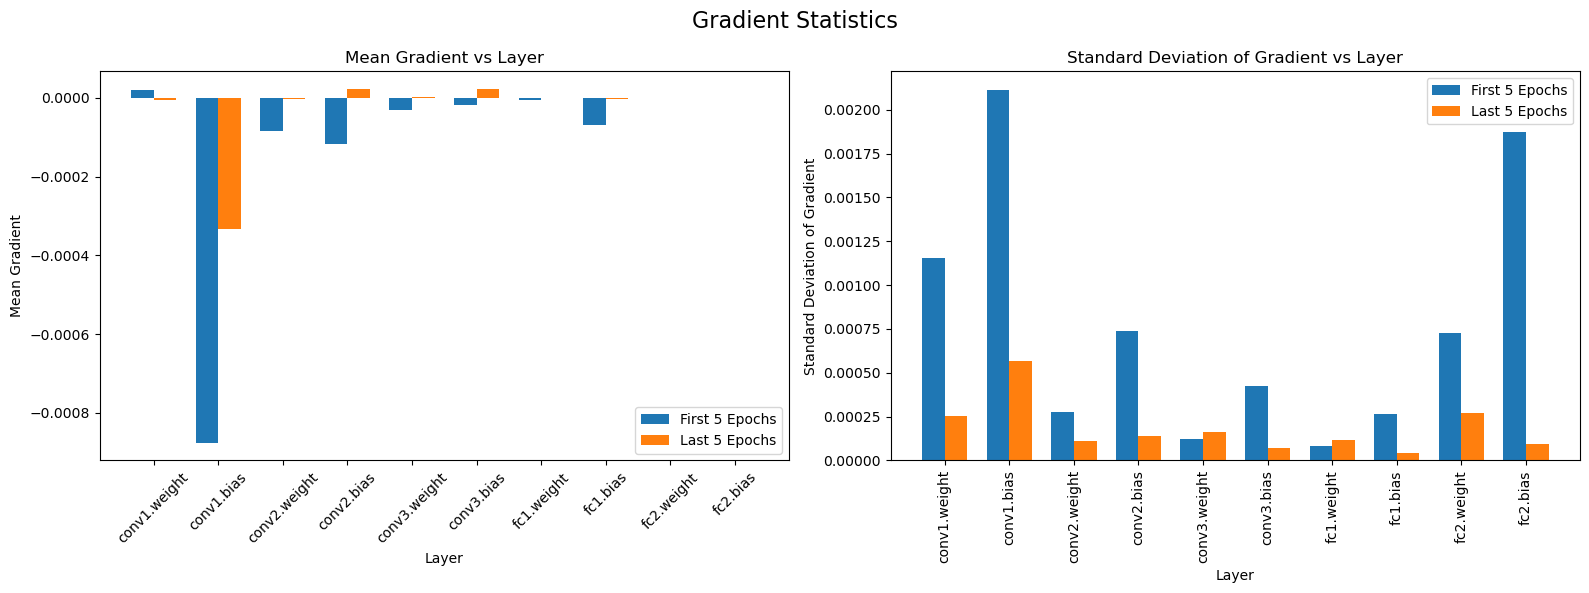

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4


KeyboardInterrupt: 

In [3]:

num_epochs = 50
learning_rate= 0.01

torch.manual_seed(0)

non_drop_model = BaselineNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(non_drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_non_drop, last_5_epochs_gradients_non_drop = collect_gradients(non_drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop = compute_gradient_statistics(first_5_epochs_gradients_non_drop)
last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop = compute_gradient_statistics(last_5_epochs_gradients_non_drop)

plot_gradient_statistics(first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop, last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop)

torch.manual_seed(0)

drop_model = DropoutNet(0.6)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_dropout, last_5_epochs_gradients_dropout = collect_gradients(drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_dropout, first_5_std_gradients_dropout = compute_gradient_statistics(first_5_epochs_gradients_dropout)
last_5_mean_gradients_dropout, last_5_std_gradients_dropout = compute_gradient_statistics(last_5_epochs_gradients_dropout)

plot_gradient_statistics(first_5_mean_gradients_dropout, first_5_std_gradients_dropout, last_5_mean_gradients_dropout, last_5_std_gradients_dropout)

torch.manual_seed(0)

bn_model = BatchNormNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(bn_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_bn, last_5_epochs_gradients_bn = collect_gradients(bn_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_bn, first_5_std_gradients_bn = compute_gradient_statistics(first_5_epochs_gradients_bn)
last_5_mean_gradients_bn, last_5_std_gradients_bn = compute_gradient_statistics(last_5_epochs_gradients_bn)

plot_gradient_statistics(first_5_mean_gradients_bn, first_5_std_gradients_bn, last_5_mean_gradients_bn, last_5_std_gradients_bn)


epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30
epoch  31
epoch  32
epoch  33
epoch  34
epoch  35
epoch  36
epoch  37
epoch  38
epoch  39
epoch  40
epoch  41
epoch  42
epoch  43
epoch  44
epoch  45
epoch  46
epoch  47
epoch  48
epoch  49


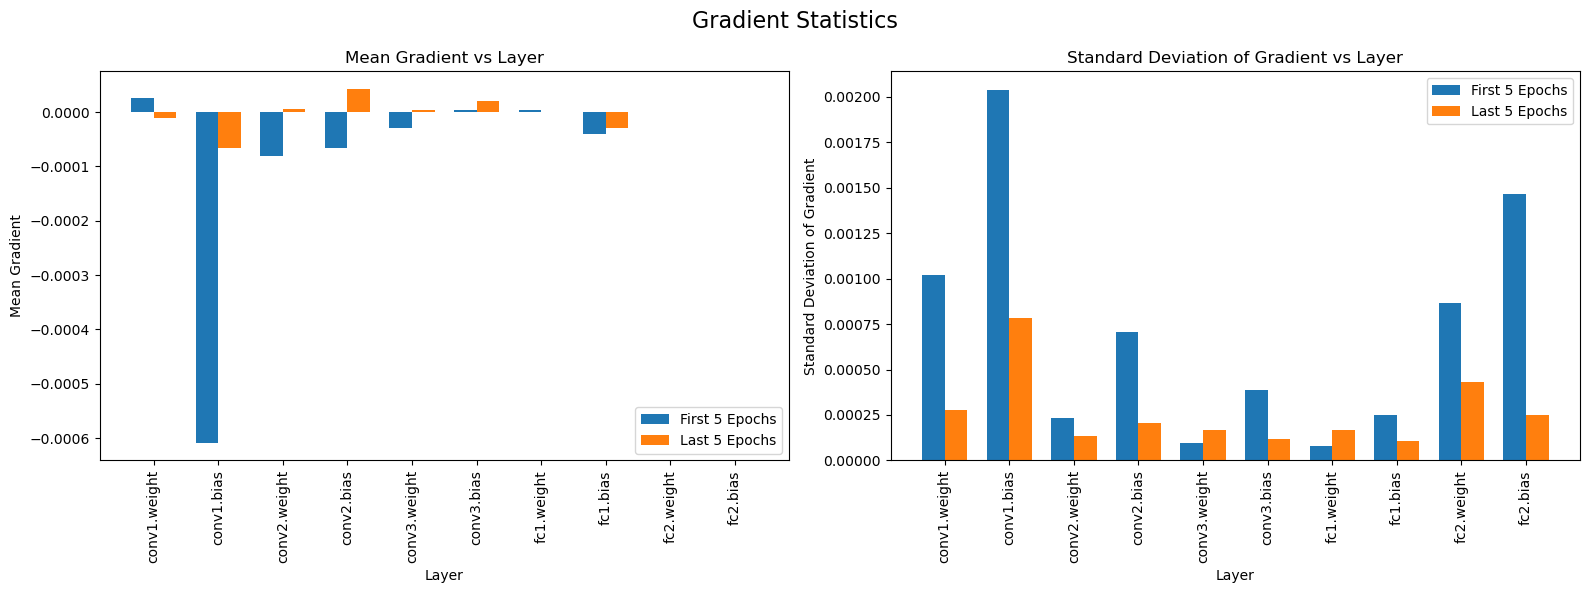

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30
epoch  31
epoch  32
epoch  33
epoch  34
epoch  35
epoch  36
epoch  37
epoch  38
epoch  39
epoch  40
epoch  41
epoch  42
epoch  43
epoch  44
epoch  45
epoch  46
epoch  47
epoch  48
epoch  49


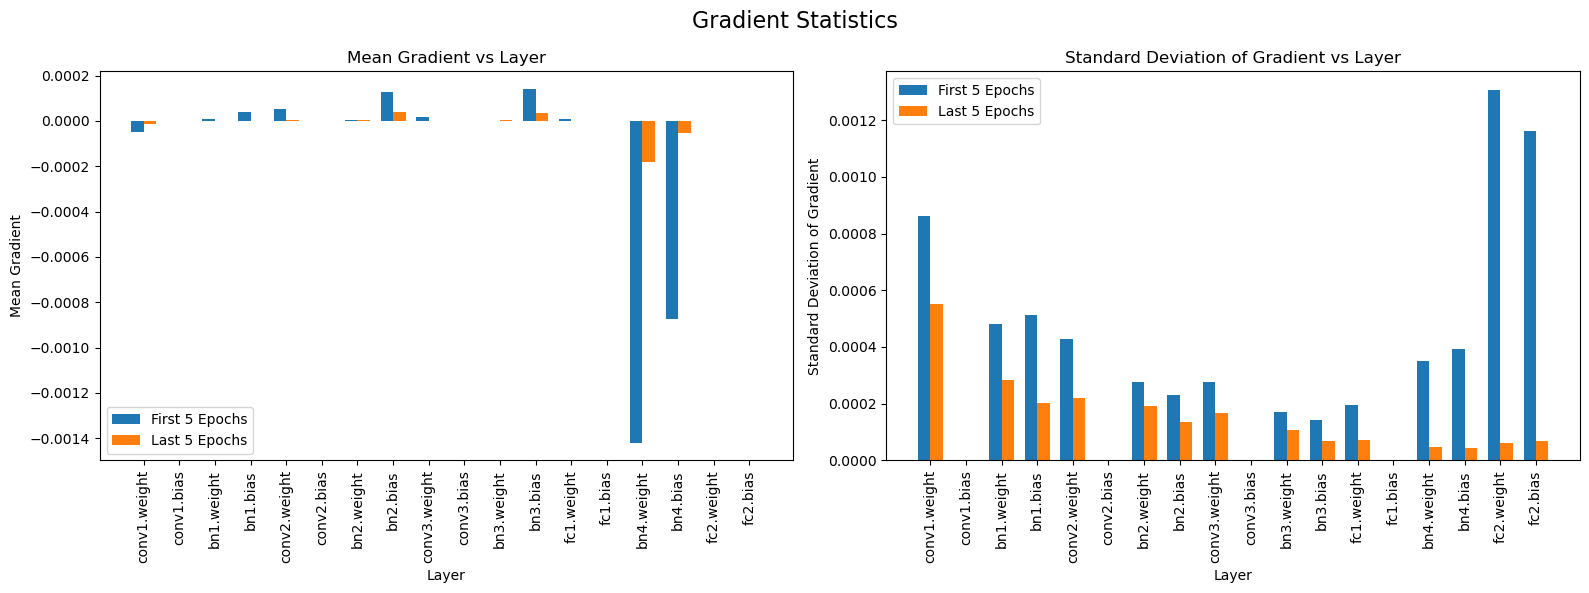

In [4]:
num_epochs = 50
learning_rate= 0.01

torch.manual_seed(0)

drop_model = DropoutNet(0.6)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_dropout, last_5_epochs_gradients_dropout = collect_gradients(drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_dropout, first_5_std_gradients_dropout = compute_gradient_statistics(first_5_epochs_gradients_dropout)
last_5_mean_gradients_dropout, last_5_std_gradients_dropout = compute_gradient_statistics(last_5_epochs_gradients_dropout)

plot_gradient_statistics(first_5_mean_gradients_dropout, first_5_std_gradients_dropout, last_5_mean_gradients_dropout, last_5_std_gradients_dropout)

torch.manual_seed(0)

bn_model = BatchNormNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(bn_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_bn, last_5_epochs_gradients_bn = collect_gradients(bn_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_bn, first_5_std_gradients_bn = compute_gradient_statistics(first_5_epochs_gradients_bn)
last_5_mean_gradients_bn, last_5_std_gradients_bn = compute_gradient_statistics(last_5_epochs_gradients_bn)

plot_gradient_statistics(first_5_mean_gradients_bn, first_5_std_gradients_bn, last_5_mean_gradients_bn, last_5_std_gradients_bn)

In [11]:
def collect_gradients_abs(model, dataloader, device, criterion, optimizer, num_epochs):
    first_5_epochs_gradients = {name: [] for name, _ in model.named_parameters()}
    last_5_epochs_gradients = {name: [] for name, _ in model.named_parameters()}
    
    for epoch in range(num_epochs):
        print('epoch ', epoch)
        model.train().to(device)
        epoch_gradients = {name: [] for name, _ in model.named_parameters()}
        
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            
            for name, param in model.named_parameters():
                if param.grad is not None:
                    epoch_gradients[name].append(torch.abs(param.grad.clone().detach()))
            
            optimizer.step()
        
        # Average the absolute gradients across the batches for each epoch
        for name in epoch_gradients.keys():
            epoch_gradients[name] = torch.stack(epoch_gradients[name]).mean(dim=0)
        
        if epoch < 5:
            for name, grad in epoch_gradients.items():
                first_5_epochs_gradients[name].append(grad)
        elif epoch >= num_epochs - 5:
            for name, grad in epoch_gradients.items():
                last_5_epochs_gradients[name].append(grad)
    
    return first_5_epochs_gradients, last_5_epochs_gradients

def compute_gradient_statistics_abs(gradients):
    mean_gradients = {}
    std_gradients = {}
    
    for layer_name, layer_gradients in gradients.items():
        layer_gradients = torch.stack(layer_gradients)
        mean_gradients[layer_name] = torch.mean(layer_gradients, dim=0)
        std_gradients[layer_name] = torch.std(layer_gradients, dim=0)
    
    return mean_gradients, std_gradients

def plot_gradient_statistics_abs(mean_gradients_first5, std_gradients_first5, mean_gradients_last5, std_gradients_last5):
    num_layers = len(mean_gradients_first5)
    layer_names = list(mean_gradients_first5.keys())
    x = np.arange(num_layers)
    width = 0.35
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Gradient Statistics (Absolute Values)', fontsize=16)
    
    # Plot mean gradients
    ax1.bar(x - width/2, [torch.mean(mean_gradients_first5[name]).item() for name in layer_names], width, label='First 5 Epochs')
    ax1.bar(x + width/2, [torch.mean(mean_gradients_last5[name]).item() for name in layer_names], width, label='Last 5 Epochs')
    ax1.set_xticks(x)
    ax1.set_xticklabels(layer_names, rotation=45)
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Mean of Absolute Gradients')
    ax1.set_title('Mean of Absolute Gradients vs Layer')
    ax1.legend()
    
    # Plot standard deviations
    ax2.bar(x - width/2, [torch.mean(std_gradients_first5[name]).item() for name in layer_names], width, label='First 5 Epochs')
    ax2.bar(x + width/2, [torch.mean(std_gradients_last5[name]).item() for name in layer_names], width, label='Last 5 Epochs')
    ax2.set_xticks(x)
    ax2.set_xticklabels(layer_names, rotation=45)
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Standard Deviation of Absolute Gradients')
    ax2.set_title('Standard Deviation of Absolute Gradients vs Layer')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29


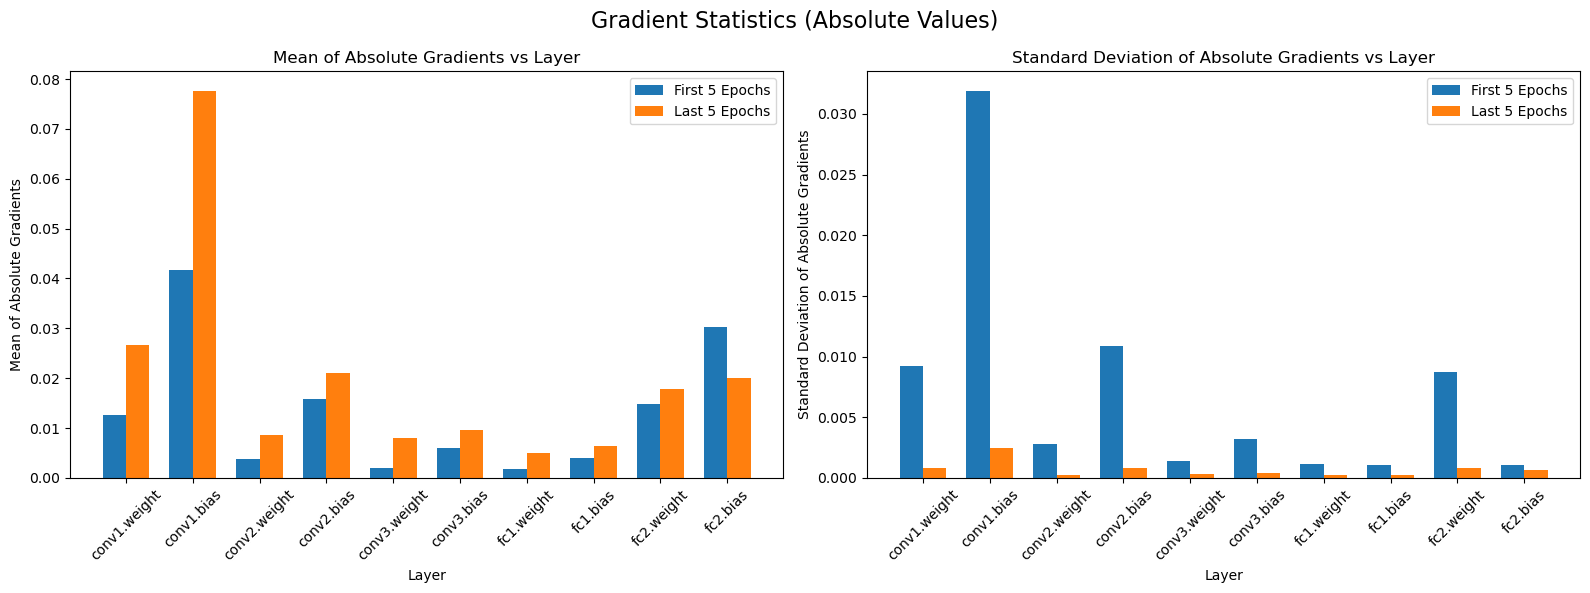

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29


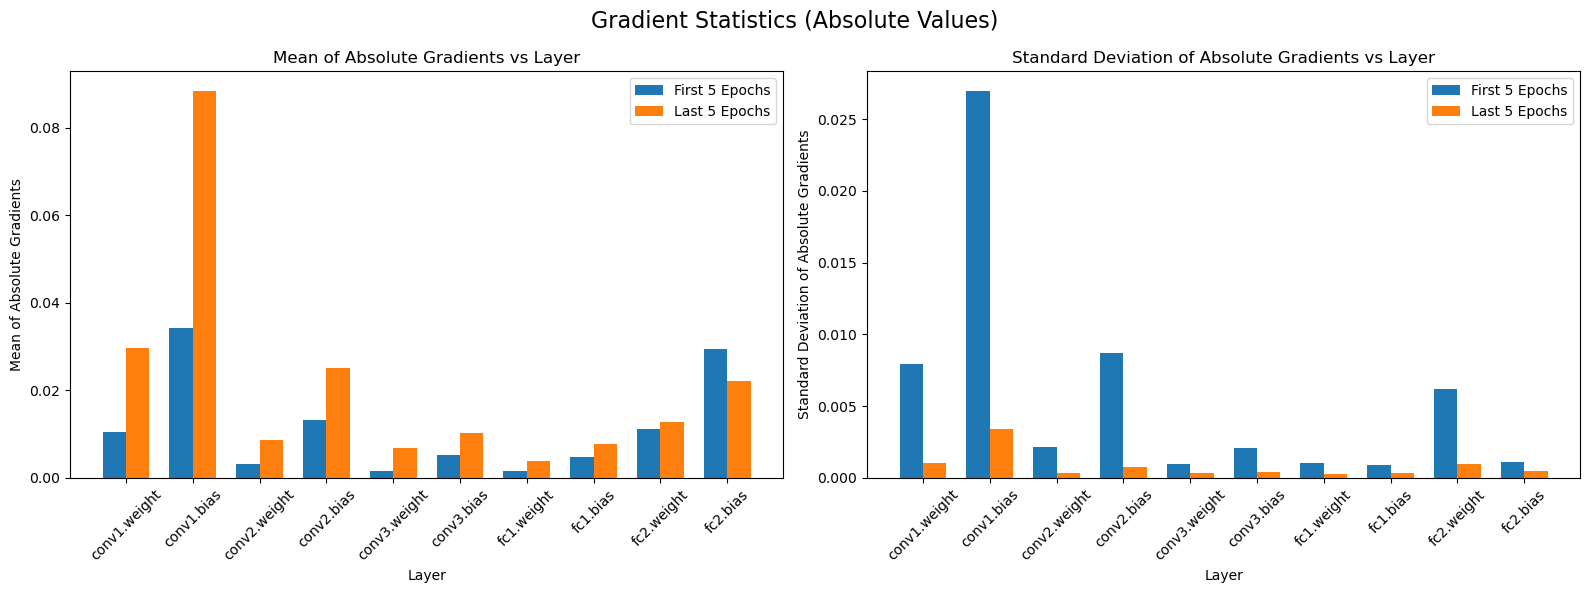

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29


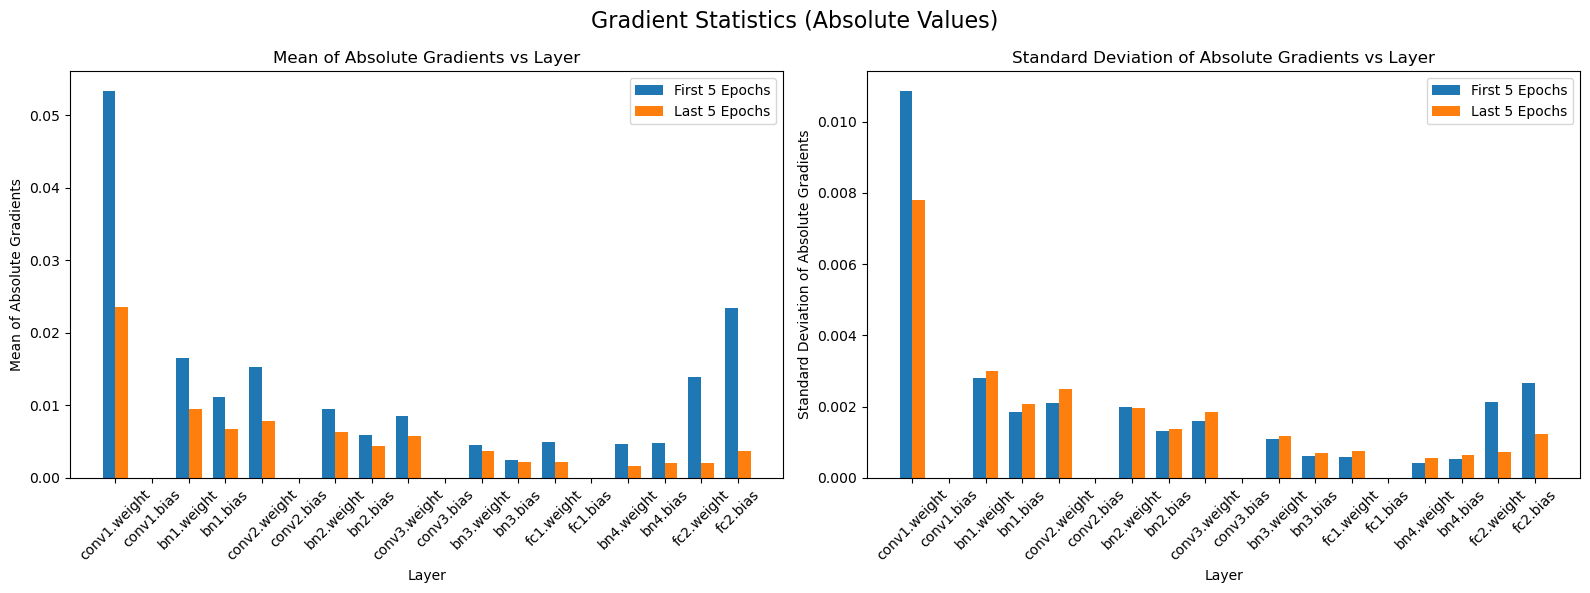

In [12]:
num_epochs = 30
learning_rate= 0.01

torch.manual_seed(0)

non_drop_model = BaselineNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(non_drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_non_drop, last_5_epochs_gradients_non_drop = collect_gradients_abs(non_drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop = compute_gradient_statistics_abs(first_5_epochs_gradients_non_drop)
last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop = compute_gradient_statistics_abs(last_5_epochs_gradients_non_drop)

plot_gradient_statistics_abs(first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop, last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop)

torch.manual_seed(0)

drop_model = DropoutNet(0.6)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_dropout, last_5_epochs_gradients_dropout = collect_gradients_abs(drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_dropout, first_5_std_gradients_dropout = compute_gradient_statistics_abs(first_5_epochs_gradients_dropout)
last_5_mean_gradients_dropout, last_5_std_gradients_dropout = compute_gradient_statistics_abs(last_5_epochs_gradients_dropout)

plot_gradient_statistics_abs(first_5_mean_gradients_dropout, first_5_std_gradients_dropout, last_5_mean_gradients_dropout, last_5_std_gradients_dropout)

torch.manual_seed(0)

bn_model = BatchNormNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(bn_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_bn, last_5_epochs_gradients_bn = collect_gradients_abs(bn_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_bn, first_5_std_gradients_bn = compute_gradient_statistics_abs(first_5_epochs_gradients_bn)
last_5_mean_gradients_bn, last_5_std_gradients_bn = compute_gradient_statistics_abs(last_5_epochs_gradients_bn)

plot_gradient_statistics_abs(first_5_mean_gradients_bn, first_5_std_gradients_bn, last_5_mean_gradients_bn, last_5_std_gradients_bn)


epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29


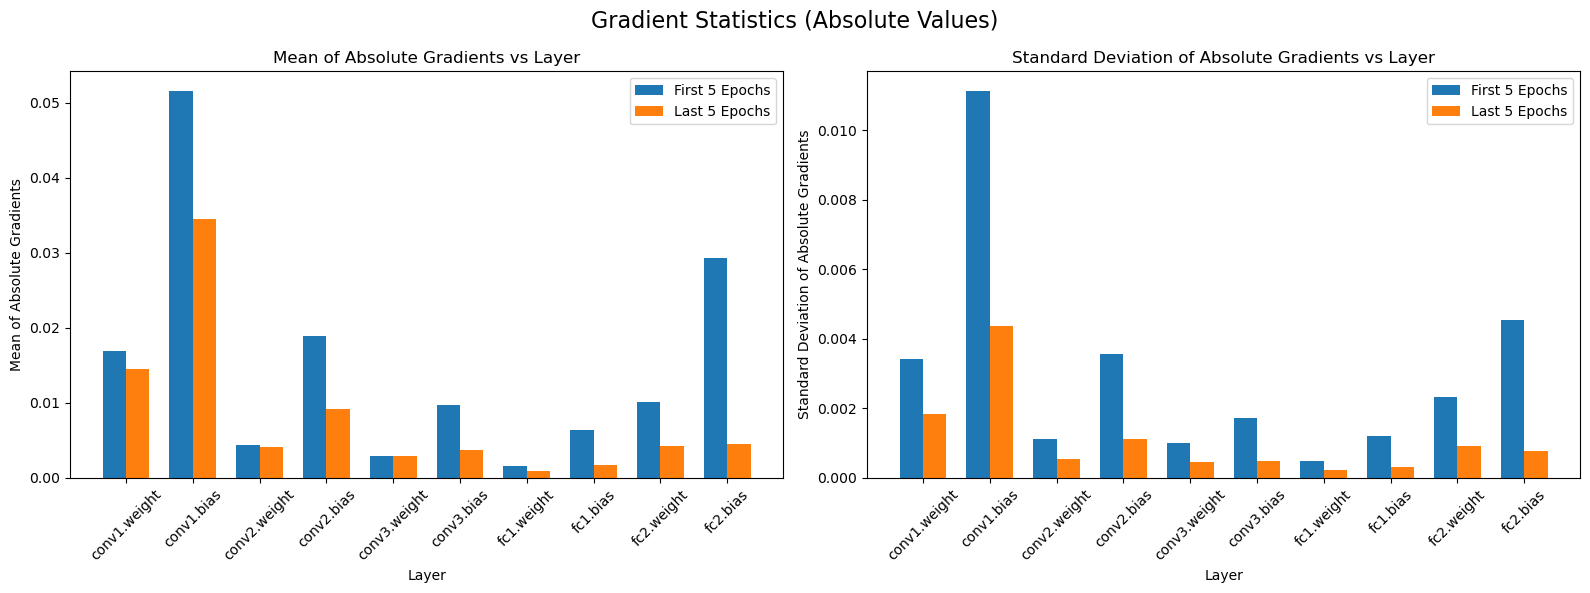

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29


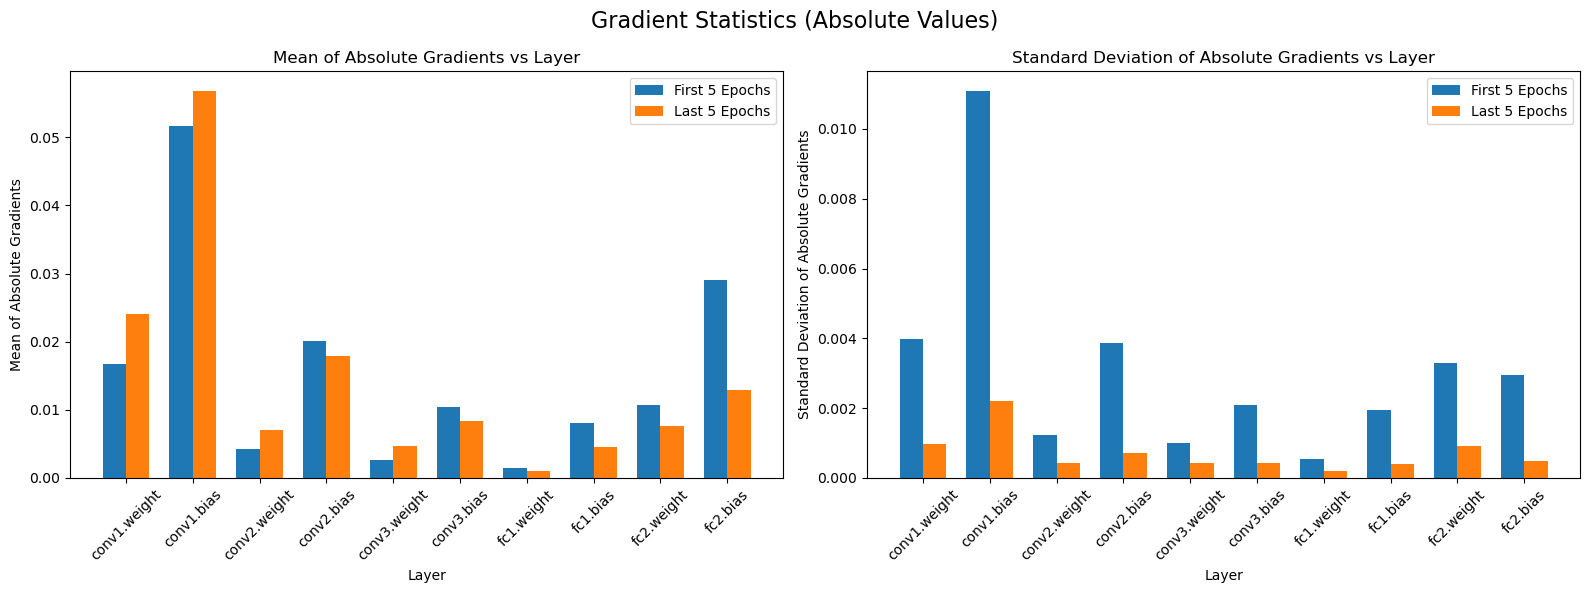

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29


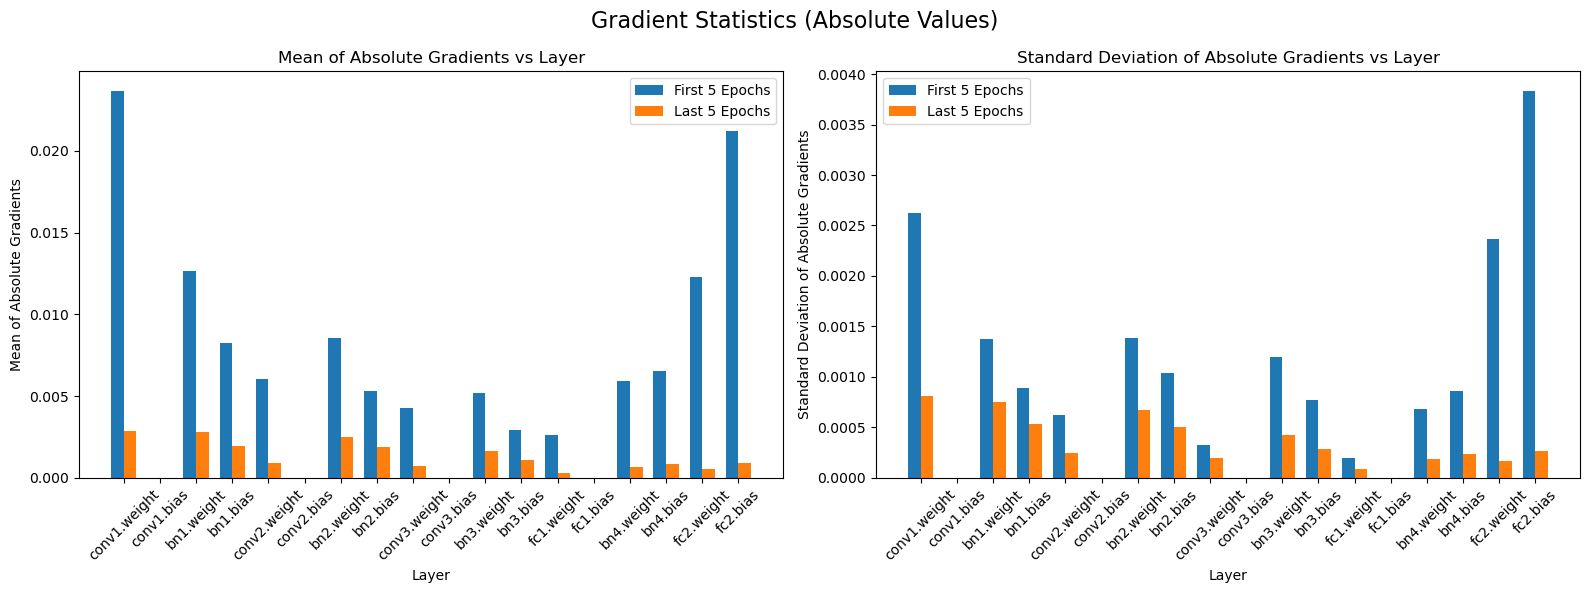

In [14]:
num_epochs = 30
learning_rate= 0.1

torch.manual_seed(0)

non_drop_model = BaselineNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(non_drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_non_drop, last_5_epochs_gradients_non_drop = collect_gradients_abs(non_drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop = compute_gradient_statistics_abs(first_5_epochs_gradients_non_drop)
last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop = compute_gradient_statistics_abs(last_5_epochs_gradients_non_drop)

plot_gradient_statistics_abs(first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop, last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop)

torch.manual_seed(0)

drop_model = DropoutNet(0.6)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_dropout, last_5_epochs_gradients_dropout = collect_gradients_abs(drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_dropout, first_5_std_gradients_dropout = compute_gradient_statistics_abs(first_5_epochs_gradients_dropout)
last_5_mean_gradients_dropout, last_5_std_gradients_dropout = compute_gradient_statistics_abs(last_5_epochs_gradients_dropout)

plot_gradient_statistics_abs(first_5_mean_gradients_dropout, first_5_std_gradients_dropout, last_5_mean_gradients_dropout, last_5_std_gradients_dropout)

torch.manual_seed(0)

bn_model = BatchNormNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(bn_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_bn, last_5_epochs_gradients_bn = collect_gradients_abs(bn_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_bn, first_5_std_gradients_bn = compute_gradient_statistics_abs(first_5_epochs_gradients_bn)
last_5_mean_gradients_bn, last_5_std_gradients_bn = compute_gradient_statistics_abs(last_5_epochs_gradients_bn)

plot_gradient_statistics_abs(first_5_mean_gradients_bn, first_5_std_gradients_bn, last_5_mean_gradients_bn, last_5_std_gradients_bn)

In [15]:
class DropoutNet_2(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=128)
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer after the first FC layer
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x) # 1st convolutional layer + ReLU + pooling
        x = F.relu(self.conv2(x))
        x = self.pool(x) # 1st convolutional layer + ReLU + pooling
        x = F.relu(self.conv3(x))
        x = self.pool(x) # 1st convolutional layer + ReLU + pooling
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.dropout(x)  # Applying dropout after activation
        x = F.relu(self.fc1(x))  # 1st fully connected layer + ReLU
        x = self.dropout(x)  # Applying dropout after activation
        x = self.fc2(x)  # 3rd fully connected layer (output)
        return x


epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29


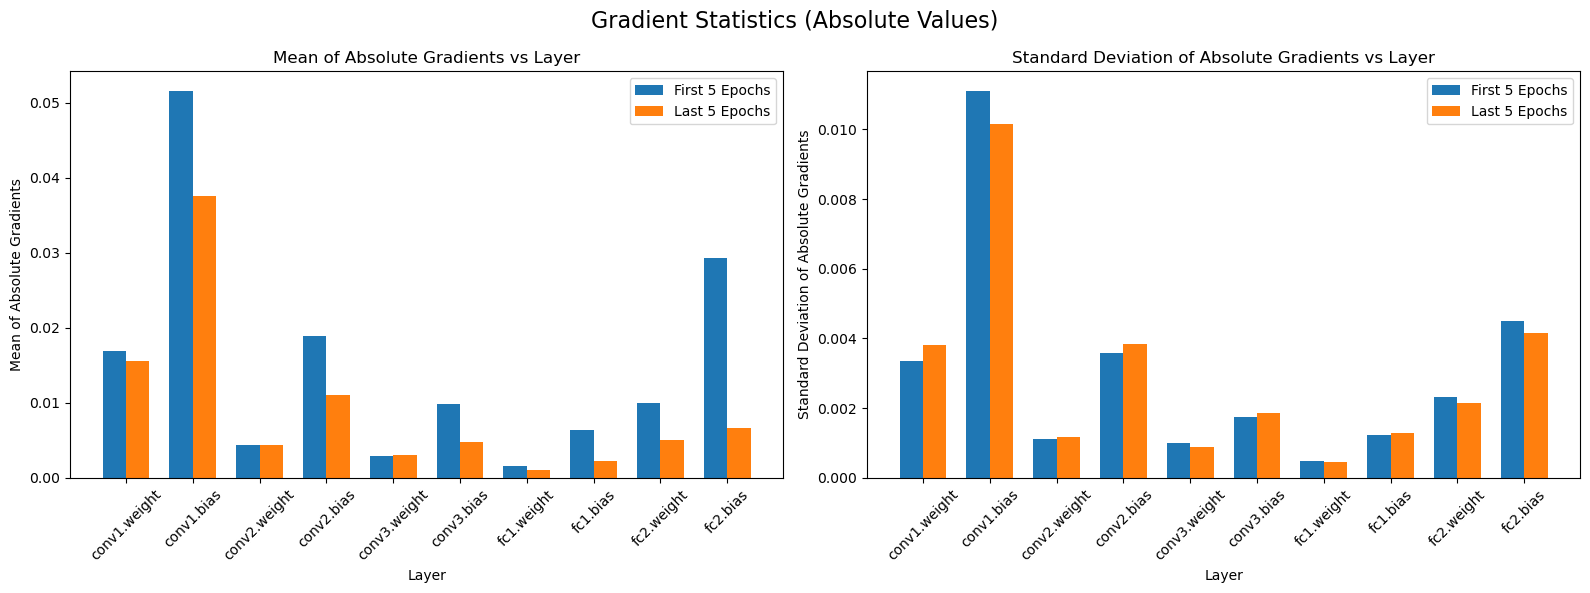

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29


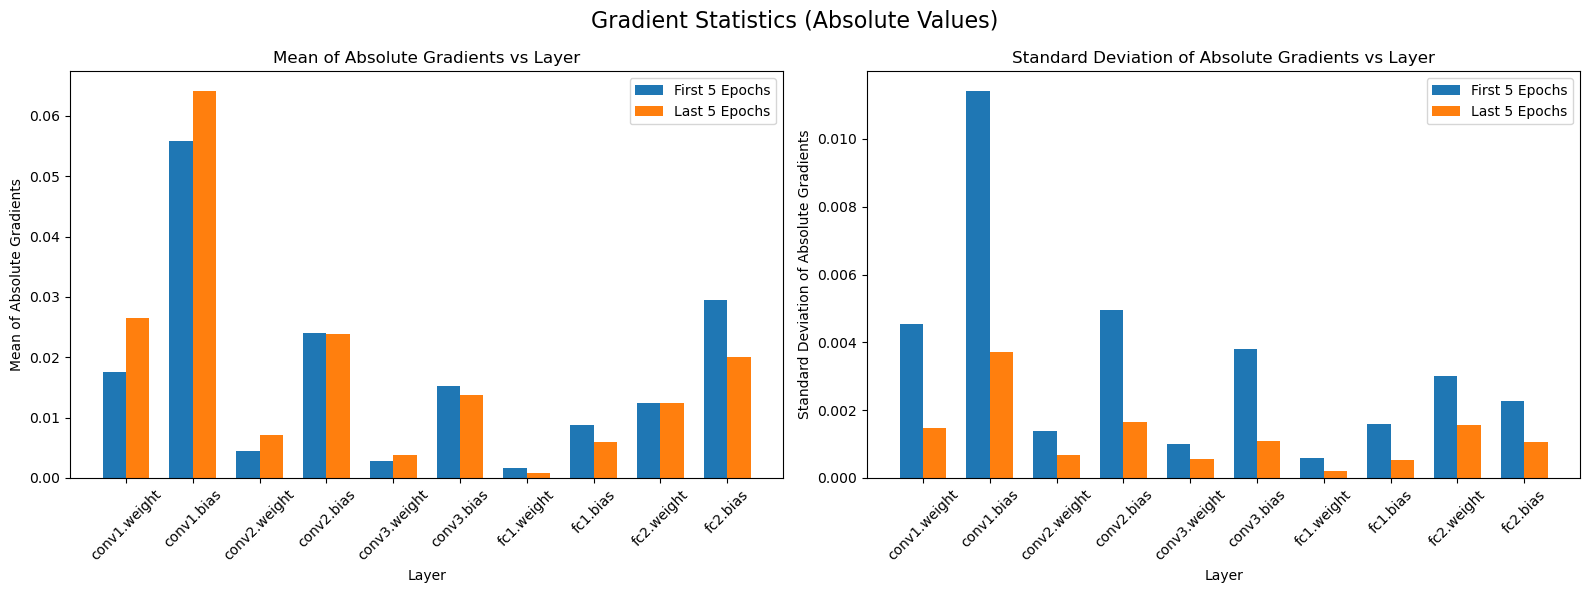

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29


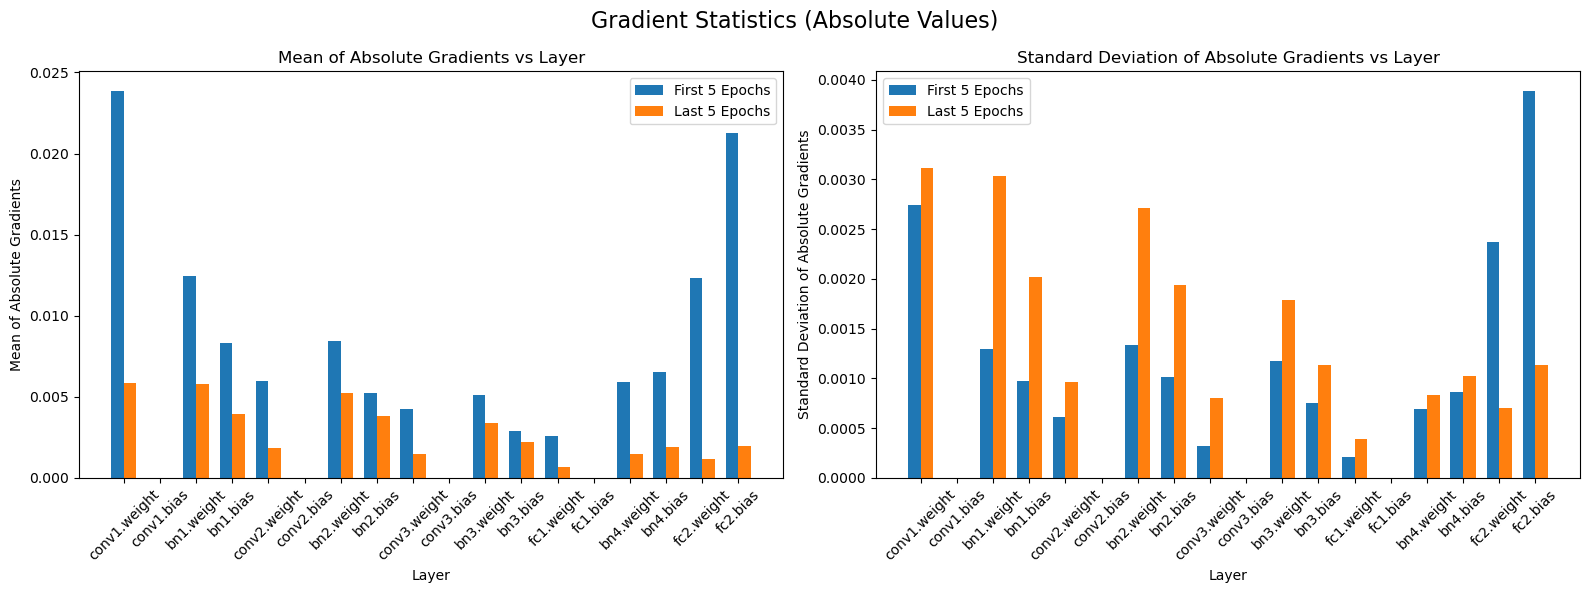

In [16]:
num_epochs = 30
learning_rate= 0.1

torch.manual_seed(0)

non_drop_model = BaselineNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(non_drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_non_drop, last_5_epochs_gradients_non_drop = collect_gradients_abs(non_drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop = compute_gradient_statistics_abs(first_5_epochs_gradients_non_drop)
last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop = compute_gradient_statistics_abs(last_5_epochs_gradients_non_drop)

plot_gradient_statistics_abs(first_5_mean_gradients_non_drop, first_5_std_gradients_non_drop, last_5_mean_gradients_non_drop, last_5_std_gradients_non_drop)

torch.manual_seed(0)

drop_model = DropoutNet_2(0.6)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(drop_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_dropout, last_5_epochs_gradients_dropout = collect_gradients_abs(drop_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_dropout, first_5_std_gradients_dropout = compute_gradient_statistics_abs(first_5_epochs_gradients_dropout)
last_5_mean_gradients_dropout, last_5_std_gradients_dropout = compute_gradient_statistics_abs(last_5_epochs_gradients_dropout)

plot_gradient_statistics_abs(first_5_mean_gradients_dropout, first_5_std_gradients_dropout, last_5_mean_gradients_dropout, last_5_std_gradients_dropout)

torch.manual_seed(0)

bn_model = BatchNormNet()
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(bn_model.parameters(), lr=learning_rate)

first_5_epochs_gradients_bn, last_5_epochs_gradients_bn = collect_gradients_abs(bn_model, train_dataloader, device, criterion, optimiser, num_epochs)

first_5_mean_gradients_bn, first_5_std_gradients_bn = compute_gradient_statistics_abs(first_5_epochs_gradients_bn)
last_5_mean_gradients_bn, last_5_std_gradients_bn = compute_gradient_statistics_abs(last_5_epochs_gradients_bn)

plot_gradient_statistics_abs(first_5_mean_gradients_bn, first_5_std_gradients_bn, last_5_mean_gradients_bn, last_5_std_gradients_bn)